##### Created by Joseph VonFeldt

### Introduction

In this project, we will create a model that detects tumours in images of brains. To do so, we will use data from [Preet Viradiya's brian-tumor-dataset on Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

Citation: 

Viradiya, P. (2021, May 16). Brian Tumor Dataset. Kaggle. https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset 

Type of Learning: Supervised Learning \\w Convolutional Neural Network

Type of Task: Classification

Goal: Detect images that show a brain with cancer.

Motivation: In theory, accurately detecting cancer could help patients recieve treatment sooner and hopefully save lives.

### Data
Image files: The data includes 2513 image files that are positive for cancer and 2087 that are negative. The images are in the following formats: PNG, JPG, and TIFF

Additionally: CSVs containing meta-data about the images, including image name, image format, image mode, image shape, and image class (tumor or normal) are included.

Size: The meta-data files are roughly 250 KB and contain ~4500 rows. The images are range from 3 KB to above 700 KB although the vast majority are 10-50 KB.


Load Packages

In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InteractiveShell.ast_node_interactivity = 'all'

### EDA

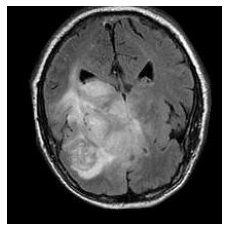

(212, 209, 3)
63.8410896452108


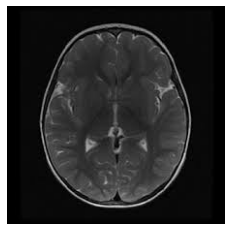

(225, 225, 3)
32.23867654320988


In [2]:
# function to show image
def showimage(path):
    image_array = np.array(PIL.Image.open(path).convert('RGB'))
    plt.axis("off")
    plt.imshow(image_array)
    plt.show()
    print(image_array.shape)
    print(image_array.mean())
# getting relevant paths to access images
cwd = os.getcwd()
cancer = cwd+'/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'
healthy = cwd+'/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'

# getting lists of paths to all images
cancer_image_paths = [cancer+s for s in os.listdir(cancer)]
healthy_image_paths = [healthy+s for s in os.listdir(healthy)]

# taking a look at two example images
showimage(cancer_image_paths[13])
showimage(healthy_image_paths[13])

In [3]:

# helper function to get information about images
def aboutimage(path):
    image_array = np.array(PIL.Image.open(path).convert('RGB'))
    out = dict()
    out['x'] = image_array.shape[0]
    out['y'] = image_array.shape[1]
    out['mean_value'] = image_array.mean()
    return pd.DataFrame(out,[0])
df_cancer = pd.DataFrame(columns=['x', 'y', 'mean_value'], dtype = 'float64')
df_healthy = pd.DataFrame(columns=['x', 'y', 'mean_value'], dtype = 'float64')

# collecting info about each cancer image
for path in cancer_image_paths:
    df_cancer = pd.concat([df_cancer,aboutimage(path)], ignore_index=True)
_ = df_cancer.reset_index()

# displaying stats about the collected info
print("Cancer Info:")
df_cancer.describe()

# collecting info about each healthy image
for path in healthy_image_paths:
    df_healthy = pd.concat([df_healthy,aboutimage(path)], ignore_index=True)
_ = df_healthy.reset_index()

# displaying stats about healthy images
print("Healthy info")
df_healthy.describe()

Cancer Info:


,x,y,mean_value
count,2513.000000,2513.000000,2513.000000
mean,432.991643,402.872264,64.826253
std,175.002203,172.740368,29.519154
min,167.000000,175.000000,15.267933
25%,318.000000,270.000000,39.893948
50%,380.000000,353.000000,60.511448
75%,512.000000,512.000000,86.016069
max,1427.000000,1275.000000,168.149389


Healthy info


,x,y,mean_value
count,2087.000000,2087.000000,2087.000000
mean,313.258745,307.249161,60.017813
std,150.214886,162.977321,21.360394
min,168.000000,150.000000,9.768337
25%,225.000000,218.000000,43.677686
50%,243.000000,232.000000,56.294025
75%,393.000000,359.000000,73.111410
max,1446.000000,1920.000000,127.158763


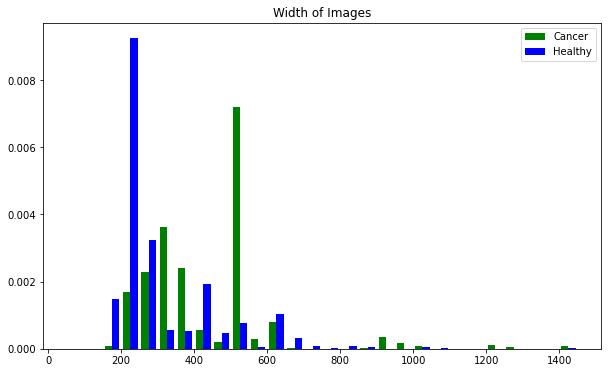

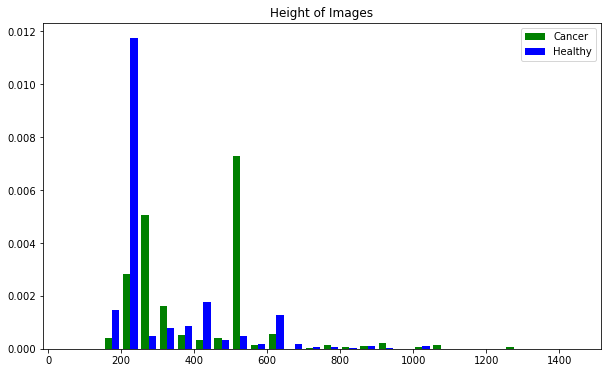

In [4]:
#plotting image size of cancer vs non-cancer images
_ =plt.figure(figsize=(10,6))
_ = plt.title("Width of Images")
bins = [i for i in range(50, 1500, 50)]
colors = ['green', 'blue']  
n_bins = 30
_ = plt.hist([df_cancer['x'], df_healthy['x']],bins, density = True,
         histtype ='bar',  
         color = colors,  
         label = ["Cancer", "Healthy"])
    
_ =plt.legend(prop ={'size': 10})  
plt.show()

_ =plt.figure(figsize=(10,6))
_ = plt.title("Height of Images")
bins = [i for i in range(50, 1500, 50)]
colors = ['green', 'blue']  
n_bins = 30
_ = plt.hist([df_cancer['y'], df_healthy['y']],bins, density = True,
         histtype ='bar',  
         color = colors,  
         label = ["Cancer", "Healthy"])
    
_ =plt.legend(prop ={'size': 10})  
plt.show()

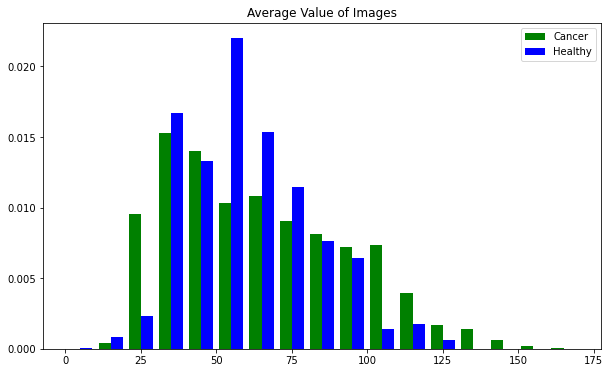

In [5]:
# Plotting average value of images
_ = plt.figure(figsize=(10,6))
_ = plt.title("Average Value of Images")
bins = [i for i in range(0, 171, 10)]
colors = ['green', 'blue']  
n_bins = 30
_ = plt.hist([df_cancer['mean_value'], df_healthy['mean_value']],bins, density = True,
         histtype ='bar',  
         color = colors,  
         label = ["Cancer", "Healthy"])
    
_ = plt.legend(prop ={'size': 10})  
plt.show()

#### EDA conclusions

It appears that there is not a large bias in average value that would indicate whether the image should be classified as Cancer or Healthy. However, it appears that images of Healthy brains are much smaller that images containing those with Cancer. Obviously, in reality, the size of the image of the brain has no bearing on whether or not the brain is healthy. We will address this issue by doing some additional data cleaning. This should let us create a model that generalizes beyond the images we are using to train.

### Data Cleaning

This dataset is generally clean to begin with. However, in order to address concerns discussed in EDA conclusions, we will remove images that are smaller than 200 px in height or in width. We will then scale all other images down to 200 by 200. 

In [6]:
# Helper Function to remove smaller images and resize larger images to 200 x 200
def imagecleaner(path, out, cancer=False, val=0):
    img = PIL.Image.open(path).convert('RGB')
    if np.array(img).shape[0] < 200 or np.array(img).shape[0] < 200:
        return val
    
    img =img.resize((200,200))
    dr = out+f"\\{'Cancer' if cancer else 'Healthy'}\\"
    newpath = dr+str(val)+".png"
    img.save(newpath)
    return val+1

newpath = cwd + "\cleaned"
try:
    os.mkdir(newpath)
except:
    pass
try:
    os.mkdir(newpath+"\Cancer")
except:
    pass
val = 0
for p in cancer_image_paths:
    val = imagecleaner(p, newpath, True, val)
try:
    os.mkdir(newpath+"\Healthy")
except:
    pass        
val = 0
for p in healthy_image_paths:
    val = imagecleaner(p, newpath, False, val)

### Model Building

#### Model from outside the class

Why a Neural Network? Neural Networks (more specifically, Convolutional Neural Networks) have been shown to outperform other less computationally demanding models in image tasks, such as object detection and in our case image classification. Convolutional Layers allow for feature detection throughout the entire image. That is to say, they can detect the something like a sharp curve or straight line throughout the entire images as opposed to only in a specific location. 

#### The isssue (or lack thereof) of Collinearity

The is of Collinearity is non-applicable to our current model and problem for several reasons. First and foremost, the variables used to construct a CNN are not something that we would try to interpret and Colliearity will affect the interpretation rather than the performance. Additionally, a CNN is necessarity not linear, so this is not applicable to begin with. 

In [7]:
import tensorflow as tf

from tensorflow.keras import layers, models

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
from random import shuffle, seed
cleaned_path = cwd+"\\cleaned"
clean_cancer_paths = [cleaned_path+"\\Cancer\\"+s for s in os.listdir(cleaned_path+"\\Cancer\\")]
clean_healthy_paths = [cleaned_path+"\\Healthy\\"+s for s in os.listdir(cleaned_path+"\\Healthy\\")]


labeled_data = [(p,1) for p in clean_cancer_paths] +[(p,0) for p in clean_healthy_paths]
# Helper function to split data
def split_train_test_val(data, train=80, test = 10, val=10):
    tot = train + test + val
    seed(69)
    shuffle(data)
    last_train = int(len(data)*train/tot)
    last_val = last_train+1+int(len(data)*val/tot)
    train = data[:last_train+1]
    val = data[last_train+1:last_val+1]
    test = data[last_val+1:]
    train_paths = [a for a,b in train]
    train_classes = [b for a,b, in train]
    
    test_paths = [a for a,b in test]
    test_classes = [b for a,b, in test]
    
    val_paths = [a for a,b in val]
    val_classes = [b for a,b, in val]
    print(len(train)/len(data))
    print(len(test)/len(data))
    print(len(val)/len(data))
    print(len(train)+len(test)+len(val), len(data))
    return train_paths, train_classes, test_paths, test_classes, val_paths, val_classes

train_paths, train_classes, test_paths, test_classes, val_paths, val_classes = split_train_test_val(labeled_data)
    

0.8001804239963916
0.09968425800631484
0.10013531799729364
4434 4434


In [9]:
# helper to build models
def buildmodel(conv32layers = 1, conv64layers = 2, denselayers = 1):
    
    hasInput = False
    model = models.Sequential()
    for i in range(conv32layers):
        if not hasInput:
            hasInput = True
            model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
        else:
            model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    for i in range(conv64layers):
        if not hasInput:
            hasInput = True
            model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)))
        else:
            model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    for i in range(denselayers):
        if not hasInput:
            hasInput=True
            model.add(layers.Dense(64, activation='relu', input_shape = (200, 200, 3)))
        else:
            model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    return model

In [35]:
def paths_to_images(paths):
    out = []
    for p in paths:
        out.append(np.array(PIL.Image.open(p).convert('RGB')))
    return np.array(out)
train_images = paths_to_images(train_paths)
test_images = paths_to_images(test_paths)
val_images = paths_to_images(val_paths)

In [11]:
def train_and_test(conv32layers = 1, conv64layers = 2, denselayers = 1):
    model = buildmodel(conv32layers, conv64layers, denselayers)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_images, np.array(train_classes),verbose=0, epochs=20, 
                        validation_data=(val_images, np.array(val_classes)))
    print(f"Model:\n\tConv32 Layers:\t{conv32layers}\n\tConv64 Layers:\t{conv64layers}\n\tDense Layers:\t{denselayers}\nFinal Test Accuracy:\t{history.history['val_accuracy'][-1]:.4f}")
    return history.history['val_accuracy'][-1], model, history

#### Hyperparameter tuning





Model:
	Conv32 Layers:	0
	Conv64 Layers:	0
	Dense Layers:	0
Final Test Accuracy:	0.8604
New Best: 0 0 0


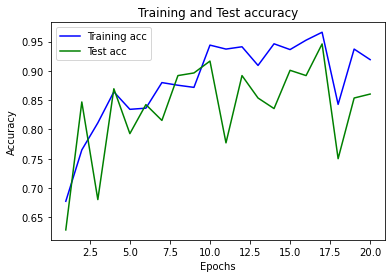

Model:
	Conv32 Layers:	0
	Conv64 Layers:	0
	Dense Layers:	1
Final Test Accuracy:	0.9459
New Best: 0 0 1


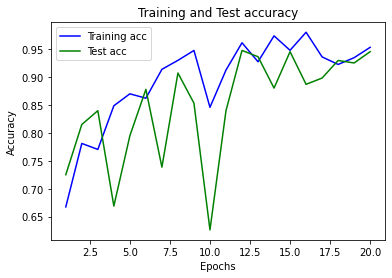

Model:
	Conv32 Layers:	0
	Conv64 Layers:	0
	Dense Layers:	2
Final Test Accuracy:	0.9392

Model:
	Conv32 Layers:	0
	Conv64 Layers:	1
	Dense Layers:	0
Final Test Accuracy:	0.9482
New Best: 0 1 0


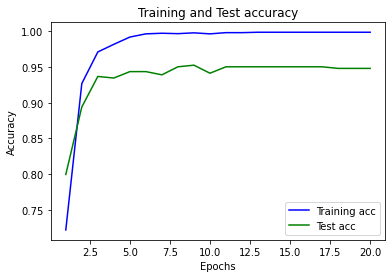

Model:
	Conv32 Layers:	0
	Conv64 Layers:	1
	Dense Layers:	1
Final Test Accuracy:	0.9550
New Best: 0 1 1


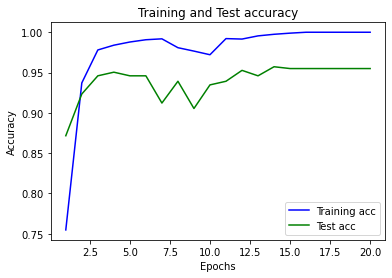

Model:
	Conv32 Layers:	0
	Conv64 Layers:	1
	Dense Layers:	2
Final Test Accuracy:	0.9640
New Best: 0 1 2


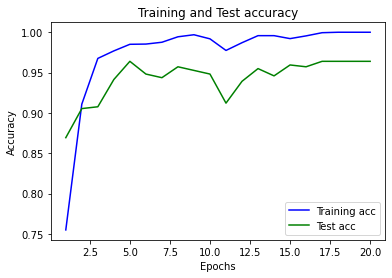

Model:
	Conv32 Layers:	0
	Conv64 Layers:	2
	Dense Layers:	0
Final Test Accuracy:	0.9437
Model:
	Conv32 Layers:	0
	Conv64 Layers:	2
	Dense Layers:	1
Final Test Accuracy:	0.9527
Model:
	Conv32 Layers:	0
	Conv64 Layers:	2
	Dense Layers:	2
Final Test Accuracy:	0.9820
New Best: 0 2 2


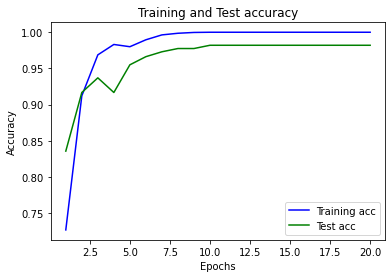

Model:
	Conv32 Layers:	0
	Conv64 Layers:	3
	Dense Layers:	0
Final Test Accuracy:	0.9640
Model:
	Conv32 Layers:	0
	Conv64 Layers:	3
	Dense Layers:	1
Final Test Accuracy:	0.9707
Model:
	Conv32 Layers:	0
	Conv64 Layers:	3
	Dense Layers:	2
Final Test Accuracy:	0.9775
Model:
	Conv32 Layers:	1
	Conv64 Layers:	0
	Dense Layers:	0
Final Test Accuracy:	0.9595
Model:
	Conv32 Layers:	1
	Conv64 Layers:	0
	Dense Layers:	1
Final Test Accuracy:	0.5541
Model:
	Conv32 Layers:	1
	Conv64 Layers:	0
	Dense Layers:	2
Final Test Accuracy:	0.9437
Model:
	Conv32 Layers:	1
	Conv64 Layers:	1
	Dense Layers:	0
Final Test Accuracy:	0.9550
Model:
	Conv32 Layers:	1
	Conv64 Layers:	1
	Dense Layers:	1
Final Test Accuracy:	0.9572
Model:
	Conv32 Layers:	1
	Conv64 Layers:	1
	Dense Layers:	2
Final Test Accuracy:	0.9572
Model:
	Conv32 Layers:	1
	Conv64 Layers:	2
	Dense Layers:	0
Final Test Accuracy:	0.9662
Model:
	Conv32 Layers:	1
	Conv64 Layers:	2
	Dense Layers:	1
Final Test Accuracy:	0.9752
Model:
	Conv32 Layers:	1
	Conv64

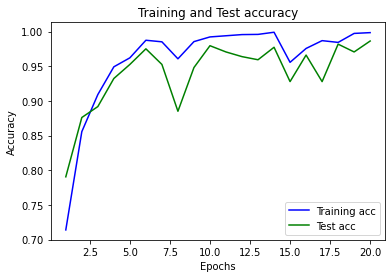

Model:
	Conv32 Layers:	2
	Conv64 Layers:	3
	Dense Layers:	0
Final Test Accuracy:	0.9550
Model:
	Conv32 Layers:	2
	Conv64 Layers:	3
	Dense Layers:	1
Final Test Accuracy:	0.9302
Model:
	Conv32 Layers:	2
	Conv64 Layers:	3
	Dense Layers:	2
Final Test Accuracy:	0.9617
Model:
	Conv32 Layers:	3
	Conv64 Layers:	0
	Dense Layers:	0
Final Test Accuracy:	0.9527
Model:
	Conv32 Layers:	3
	Conv64 Layers:	0
	Dense Layers:	1
Final Test Accuracy:	0.9595
Model:
	Conv32 Layers:	3
	Conv64 Layers:	0
	Dense Layers:	2
Final Test Accuracy:	0.9730
Model:
	Conv32 Layers:	3
	Conv64 Layers:	1
	Dense Layers:	0
Final Test Accuracy:	0.9662
Model:
	Conv32 Layers:	3
	Conv64 Layers:	1
	Dense Layers:	1
Final Test Accuracy:	0.9685
Model:
	Conv32 Layers:	3
	Conv64 Layers:	1
	Dense Layers:	2
Final Test Accuracy:	0.9595
Model:
	Conv32 Layers:	3
	Conv64 Layers:	2
	Dense Layers:	0
Final Test Accuracy:	0.9617
Model:
	Conv32 Layers:	3
	Conv64 Layers:	2
	Dense Layers:	1
Final Test Accuracy:	0.9730
Model:
	Conv32 Layers:	3
	Conv64

In [12]:
best = None
histories = dict()
for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        for k in [0, 1, 2]:
            acc, model, his = train_and_test(i,j,k)
            histories[(i,j, k)] = his
            if best == None or best[0] < acc:
                print("New Best:", i, j, k )
                best = [acc, i, j, k, model ]
                # _ =  is to avoid excess logging
                _ = plt.plot([i+1 for i in range(20)], his.history["accuracy"], 'b', label='Training acc')
                _ = plt.plot([i+1 for i in range(20)],  his.history["val_accuracy"], 'g', label='Val acc')
                _ = plt.title('Training and Validation accuracy')
                _ = plt.xlabel('Epochs')
                _ = plt.ylabel('Accuracy')
                _ = plt.legend()
                _ = plt.show()

### Results and Analysis

#### Visualizations

(2, 2, 2) 0.9864864945411682


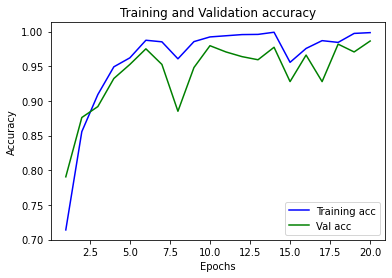

(2, 1, 0) 0.9819819927215576


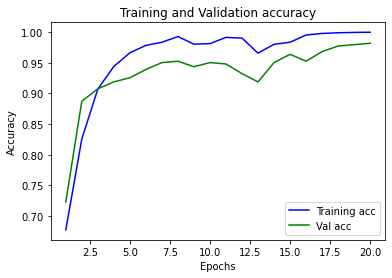

(0, 2, 2) 0.9819819927215576


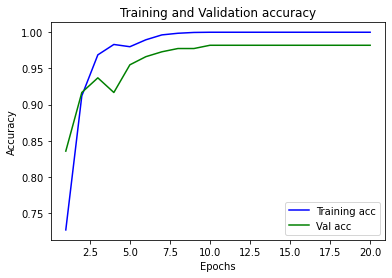

(3, 3, 1) 0.977477490901947


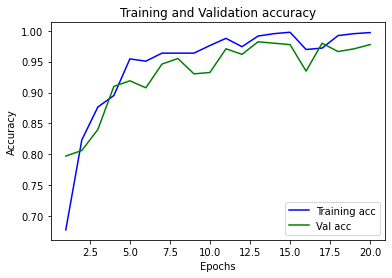

(3, 3, 0) 0.977477490901947


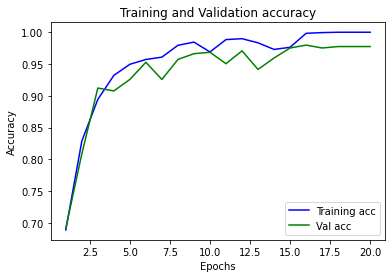

(3, 2, 2) 0.977477490901947


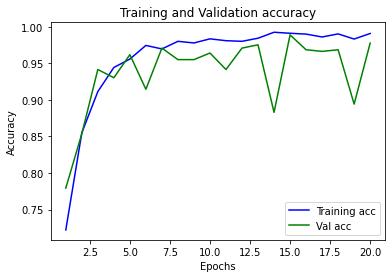

(1, 3, 1) 0.977477490901947


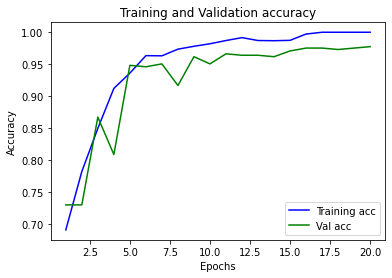

(0, 3, 2) 0.977477490901947


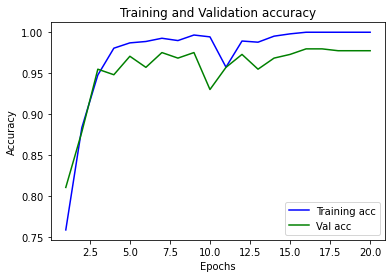

(2, 0, 1) 0.9752252101898193


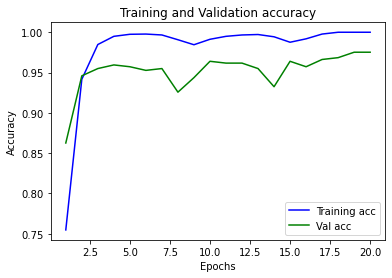

(1, 2, 1) 0.9752252101898193


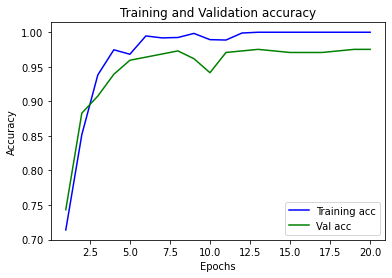

(3, 2, 1) 0.9729729890823364


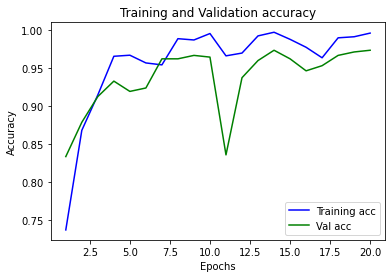

(3, 0, 2) 0.9729729890823364


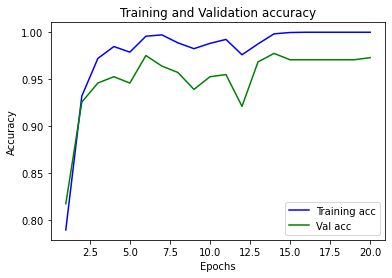

(2, 1, 2) 0.9729729890823364


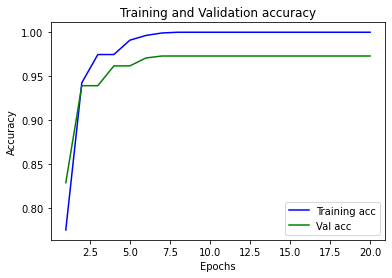

(2, 2, 1) 0.9707207083702087


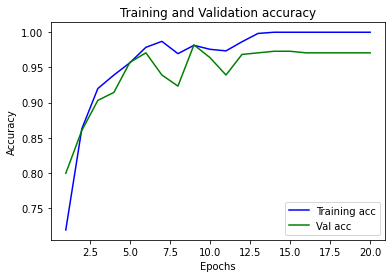

(2, 0, 2) 0.9707207083702087


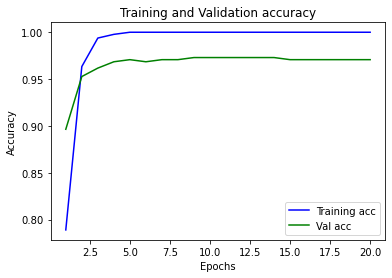

(0, 3, 1) 0.9707207083702087


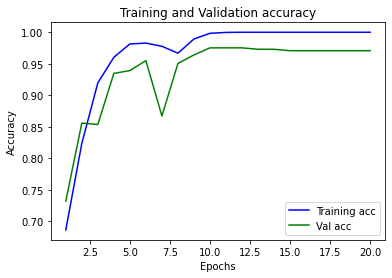

In [19]:
high_accs = []
for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        for k in [0, 1, 2]:
            his = histories[(i,j, k)]
            if his.history['val_accuracy'][-1] > .97:
                high_accs.append((his.history['val_accuracy'][-1],(i,j,k),his))
high_accs.sort(reverse=True)
for _, vals, his in high_accs:
    print(vals, _)
    _ = plt.plot([i+1 for i in range(20)], his.history["accuracy"], 'b', label='Training acc')
    _ = plt.plot([i+1 for i in range(20)],  his.history["val_accuracy"], 'g', label='Val acc')
    _ = plt.title('Training and Validation accuracy')
    _ = plt.xlabel('Epochs')
    _ = plt.ylabel('Accuracy')
    _ = plt.legend()
    _ = plt.show()

Despite ending up with the highest final Validation Accuracy, looking at the Training vs Validation Accuracy Graph tells us that the 2,2,2 model probably isn't the best. It appears to be high variance and to have just gotten lucky at the end. The following models architectures appear to have less variance with similar final Validation Accuarcy, so we'll move forward with them:

(2,1,0), (0,2,2), (3,3,0), (1,3,1), (1,2,1), and (2,1,2) 

#### Various Evaluation Metrics

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

def train_and_evaluate(conv32layers = 1, conv64layers = 2, denselayers = 1):
    model = buildmodel(conv32layers, conv64layers, denselayers)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    history = model.fit(train_images, np.array(train_classes),verbose=0, epochs=20, 
                        validation_data=(val_images, np.array(val_classes)))
    preds = np.array([ 0 if a>b else 1 for a,b in model.predict(val_images)])
    auc = roc_auc_score(np.array(val_classes), model.predict(val_images)[:, 1])
    f1 = f1_score(np.array(val_classes), preds)
    print(f"Model:\n\tConv32 Layers:\t{conv32layers}\n\tConv64 Layers:\t{conv64layers}\n\tDense Layers:\t{denselayers}\nFinal Test Accuracy:\t{history.history['val_accuracy'][-1]:.4f}\nFinal AUC:\t{auc:.4f}\nFinal F1:\t{f1:.4f}\n")
    return  model
for a,b,c in [(2,1,0), (0,2,2), (3,3,0), (1,3,1), (1,2,1), (2,1,2) ]:
    _ = train_and_evaluate(a,b,c)

14/14 [==============================] - 0s 31ms/step
Model:
	Conv32 Layers:	2
	Conv64 Layers:	1
	Dense Layers:	0
Final Test Accuracy:	0.9550
Final AUC:	0.9884
Final F1:	0.9602



14/14 [==============================] - 1s 69ms/step
Model:
	Conv32 Layers:	0
	Conv64 Layers:	2
	Dense Layers:	2
Final Test Accuracy:	0.9775
Final AUC:	0.9863
Final F1:	0.9799



14/14 [==============================] - 0s 30ms/step
Model:
	Conv32 Layers:	3
	Conv64 Layers:	3
	Dense Layers:	0
Final Test Accuracy:	0.9842
Final AUC:	0.9828
Final F1:	0.9859



14/14 [==============================] - 1s 43ms/step
Model:
	Conv32 Layers:	1
	Conv64 Layers:	3
	Dense Layers:	1
Final Test Accuracy:	0.9752
Final AUC:	0.9913
Final F1:	0.9779



14/14 [==============================] - 1s 42ms/step
Model:
	Conv32 Layers:	1
	Conv64 Layers:	2
	Dense Layers:	1
Final Test Accuracy:	0.9730
Final AUC:	0.9857
Final F1:	0.9758



14/14 [==============================] - 0s 31ms/step
Model:
	Conv32 Layers:	2
	Conv64 Layers:	1
	Dense Layers:	2
Final Test Accuracy:	0.9662
Final AUC:	0.8671
Final F1:	0.9699



#### Final Model Selection

From the metrics above, we can conclude that (3,3,0) is a good model architecture to select. We will address the claim that it is good and not necessarily the best in the Conclusion section.

In [41]:
final_model = train_and_evaluate(3,3,0)

14/14 [==============================] - 0s 30ms/step
Model:
	Conv32 Layers:	3
	Conv64 Layers:	3
	Dense Layers:	0
Final Test Accuracy:	0.9797
Final AUC:	0.9573
Final F1:	0.9817



#### Final Model Perfomance on Unseen Data

In [42]:
preds = np.array([ 0 if a>b else 1 for a,b in final_model.predict(test_images)])
auc = roc_auc_score(np.array(test_classes), final_model.predict(test_images)[:, 1])
f1 = f1_score(np.array(test_classes), preds)
acc = accuracy_score(np.array(test_classes), preds)
print(f"Final Accuracy:\t{acc:.4f}\nFinal AUC:\t{auc:.4f}\nFinal F1:\t{f1:.4f}\n")

14/14 [==============================] - 0s 30ms/step
Final Accuracy:	0.9729
Final AUC:	0.9654
Final F1:	0.9765



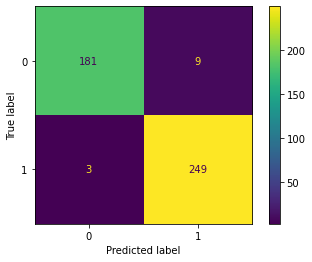

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_classes, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

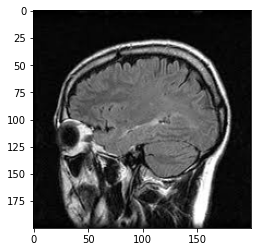

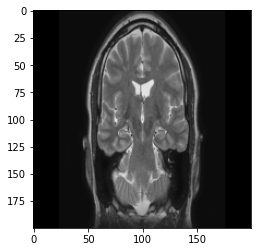

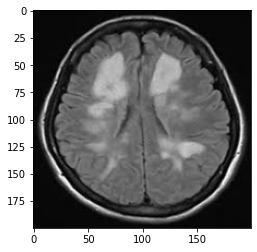

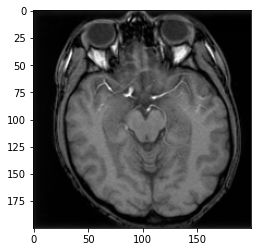

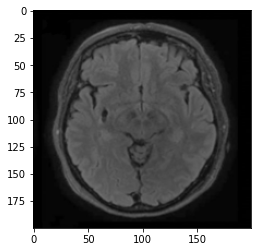

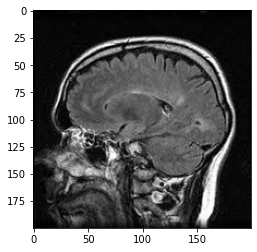

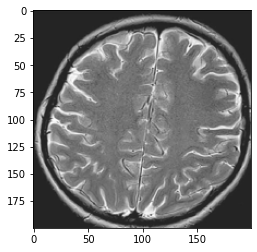

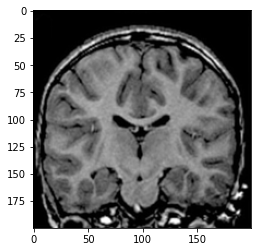

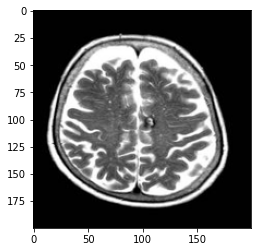

In [49]:
# plotting False Positives
for i in range(len(test_classes)):
    if preds[i] and not test_classes[i]:
        plt.imshow(test_images[i])
        plt.show()

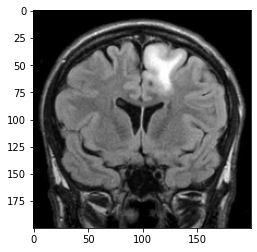

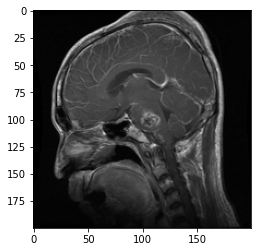

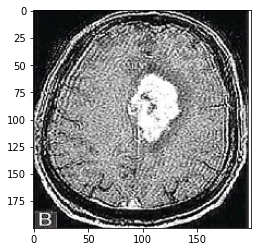

In [51]:
# plotting False Negatives
for i in range(len(test_classes)):
    if not preds[i] and test_classes[i]:
        plt.imshow(test_images[i])
        plt.show()

### Conclusion

#### Takeaways

Overall, this project was successful. We were able to create a model that could detect cancer in completely new images of brains with greater than 97% accuarcy. This or some similar model could potentially be used by doctors to determine whether further investigation is needed or a diagnosis can be made.

However, 97% certainly isn't high enough accuracy to replace expert humans, so if this was intended to be used as anything aside from a weak aid, significant improvements would need to be made. 

#### Why didn't we select the model architecture with the highest validation accuracy?

One thing that you may have noticed is that the model architecture that had the highest validation accuracy in our initial run wasn't one of the final architecutres we examined. This is because validation accuracy graph showed large swings up and down indicating that there may be large variance associated with this model architecture. 
##### However, it is worth noting that this may have been an issue with the initial random state of the model rather than the architure. With more time and compute resources, it would be worth training several unique models with each architecture and doing a more thorough investigation to select a model architecture

#### Possible improvements

As noted above, doing a more thorough analysis of model architectures may lead to selecting a better architecture.

Additionaly, you may have noticed that the imagaes of brains are taken from multiple angles. Creating a unique model for each angle, may lead to improved performance. 

It is possible that use an ensemble rather than an individual CNN would result in better performance.